In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import os

#import scienceplots
#
#plt.style.use(['ieee','std-colors'])
#plt.rcParams.update({
#    "font.family": "serif",   # specify font family here
#    "font.serif": ["Times New Roman"],  # specify font here
#    "font.size":11})          # specify font size here


In [42]:
def plot_joint_states(joint_states, target="Position", fig=None, axs=None):
    if fig is None:
        fig, axs = plt.subplots(2, 3, figsize=(12, 8))
        fig.tight_layout(pad=5.0)

    for i, ax in enumerate(axs.flat):
        ax.plot(joint_states[:, i])
        ax.set_title(f'Joint {i+1}')
        ax.set_xlabel('Time')
        ax.set_ylabel(f'{target}')

    return fig, axs


In [43]:
import torch
import math
eval_states = torch.load("./Evaluation_States_real.pt",weights_only=True)
# :6 Init Joints Pos
# 6:9 Target Pos
# 9:11 object size (height, width)
# 11:14 object color
init_joint_pos = eval_states[:, :6].clone().cpu().numpy()



In [44]:
exp_name = "NPT"
model = "Optimal" #"BR_20Hz_Full_DG, BR_20Hz_Robust_COM", "BR_20Hz_Robust_POS"
targetObject = "woodBlock" # None, "powerDrill", "screwdriver", "screw" "multi_noodle", "multi_bottle"


target = "block" if targetObject is None else f"{targetObject}"
library = "rl_games" #"skrl"
seed = 0
dataset_dir = f"../results/{library}/{exp_name}/{model}/{target}/seed{{}}"
traj_list = os.listdir(dataset_dir.format(seed))


In [45]:
succTrajs = []
block_pos_Error = []
ACC = []
ACTION = []
n_success = 0
n_drops = 0
for seed in range(1):
    results_dir = f"../results/{library}/{exp_name}/{model}/{target}/seed{{}}" #DYN_IL
    print("Results Directory: ", results_dir.format(seed))
    for i in range(32):
        traj_ind = "{:03d}".format(i)
        obs_traj = np.loadtxt(os.path.join(results_dir.format(seed), traj_ind,"obs_traj.txt"), delimiter=',')
        success_traj = np.loadtxt(os.path.join(results_dir.format(seed), traj_ind,"success_traj.txt"), delimiter=',')
        notDropped = np.loadtxt(os.path.join(results_dir.format(seed), traj_ind,"notDropped.txt"), delimiter=',')[i]#[i%32]
        states_traj = np.loadtxt(os.path.join(results_dir.format(seed), traj_ind,"states_traj.txt"), delimiter=',')
        action_traj = np.loadtxt(os.path.join(results_dir.format(seed), traj_ind,"action_traj.txt"), delimiter=',')
        jointacc_traj = np.loadtxt(os.path.join(dataset_dir.format(seed), traj_ind,"jointacc_traj.txt"), delimiter=',')[:,:]

        if not notDropped:
            n_drops += 1


        ee_pos_error  = states_traj[:, 0]
        block_pos_error = states_traj[:, 1]
        block_ori_error = states_traj[:, 2]
        ee_vel = states_traj[:, 3]

        ee_pos = obs_traj[:, 12:15]*100
        object_pos = obs_traj[:, 27:30]*100
        object_relPos = object_pos - ee_pos

        #print(success_traj)
        is_success = (sum(success_traj)==len(success_traj)) and (ee_pos_error[-10:].mean() < 0.1)

        X = np.arange(len(ee_pos_error))
        
        if is_success:
            #print("Success: ", traj_ind)
            n_success += 1  
            succTrajs.append(traj_ind)
            ACC.append(jointacc_traj)
            ACTION.append(action_traj)
            
        block_pos_Error.append(block_pos_error)
print(f"n_success: {100*n_success/32}")
print(f"n_drops: {100*n_drops/32}")
print("Success Trajs: ", succTrajs)


Results Directory:  ../results/rl_games/NPT/Optimal/woodBlock/seed0
n_success: 100.0
n_drops: 0.0
Success Trajs:  ['000', '001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031']


ACC mean:  [-0.00247082  0.00340761 -0.00080169 -0.01195934 -0.00748648  0.00137921]
ACC std:  [2.70775785 1.76781497 1.4465481  1.7444     1.42031214 1.86628259]
ACC min:  [ -9.14125633 -10.          -5.5019331  -10.          -5.71723747
  -7.8093729 ]
ACC max:  [11.46403217  5.73527622  7.11519051  5.504035    5.45377541  8.9902668 ]


(<Figure size 1200x800 with 6 Axes>,
 array([[<Axes: title={'center': 'Joint 1'}, xlabel='Time', ylabel='Acceleration'>,
         <Axes: title={'center': 'Joint 2'}, xlabel='Time', ylabel='Acceleration'>,
         <Axes: title={'center': 'Joint 3'}, xlabel='Time', ylabel='Acceleration'>],
        [<Axes: title={'center': 'Joint 4'}, xlabel='Time', ylabel='Acceleration'>,
         <Axes: title={'center': 'Joint 5'}, xlabel='Time', ylabel='Acceleration'>,
         <Axes: title={'center': 'Joint 6'}, xlabel='Time', ylabel='Acceleration'>]],
       dtype=object))

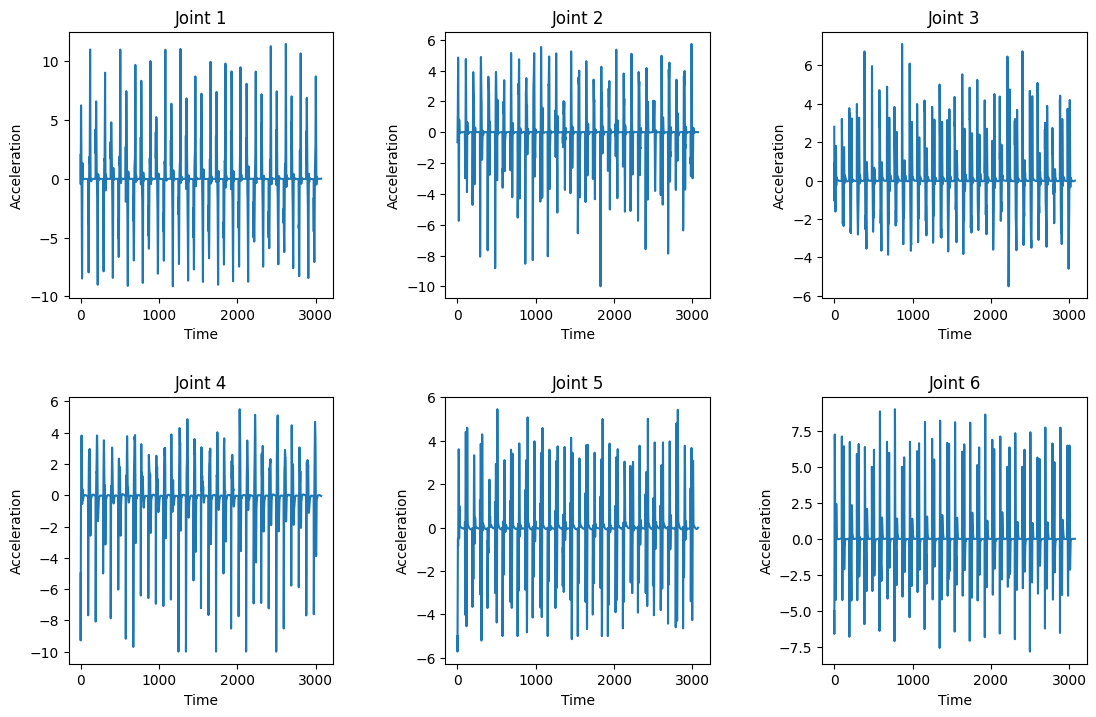

In [46]:
ACC = np.concatenate(ACC, axis=0)
# ACC statistics
print("ACC mean: ", ACC.mean(axis=0))
print("ACC std: ", ACC.std(axis=0))
print("ACC min: ", ACC.min(axis=0))
print("ACC max: ", ACC.max(axis=0))
plot_joint_states(ACC, target="Acceleration")

ACTION mean:  [ 8.13875583e-06  1.82446480e-05  6.60425606e-06 -1.20527658e-04
  2.06523412e-05  4.51598844e-05]
ACTION std:  [0.17045832 0.13265492 0.11111822 0.15258217 0.12369999 0.19000306]
ACTION min:  [-1.        -1.        -0.6202957 -1.        -1.        -1.       ]
ACTION max:  [0.96401572 0.58155352 1.         0.63442779 0.5688448  1.        ]


(<Figure size 1200x800 with 6 Axes>,
 array([[<Axes: title={'center': 'Joint 1'}, xlabel='Time', ylabel='ACTION'>,
         <Axes: title={'center': 'Joint 2'}, xlabel='Time', ylabel='ACTION'>,
         <Axes: title={'center': 'Joint 3'}, xlabel='Time', ylabel='ACTION'>],
        [<Axes: title={'center': 'Joint 4'}, xlabel='Time', ylabel='ACTION'>,
         <Axes: title={'center': 'Joint 5'}, xlabel='Time', ylabel='ACTION'>,
         <Axes: title={'center': 'Joint 6'}, xlabel='Time', ylabel='ACTION'>]],
       dtype=object))

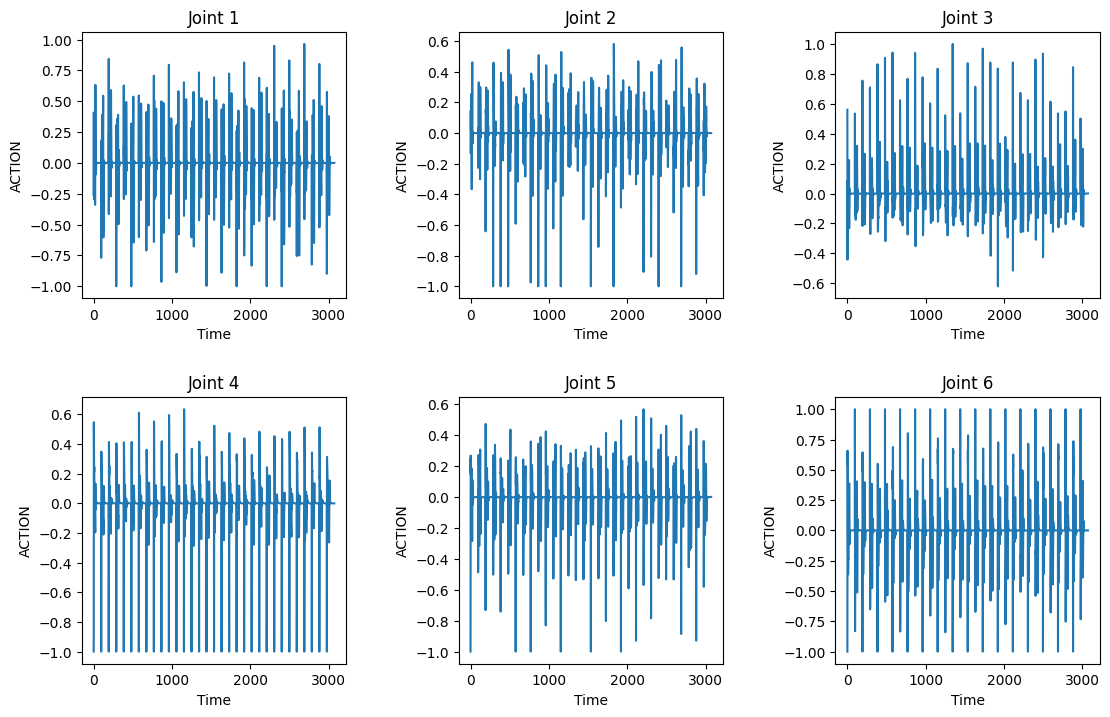

In [47]:
ACTION = np.concatenate(ACTION, axis=0)
# ACTION statistics
print("ACTION mean: ", ACTION.mean(axis=0))
print("ACTION std: ", ACTION.std(axis=0))
print("ACTION min: ", ACTION.min(axis=0))
print("ACTION max: ", ACTION.max(axis=0))
plot_joint_states(ACTION, target="ACTION")

In [48]:
traj_ind = "001"
obs_traj = np.loadtxt(os.path.join(dataset_dir.format(seed), traj_ind,"obs_traj.txt"), delimiter=',')
action_traj = np.loadtxt(os.path.join(dataset_dir.format(seed), traj_ind,"action_traj.txt"), delimiter=',')[:,:]
jointacc_traj = np.loadtxt(os.path.join(dataset_dir.format(seed), traj_ind,"jointacc_traj.txt"), delimiter=',')[:,:]

joint_pos = obs_traj[:, :6]
joint_vel = obs_traj[:, 6:12]

ee_pos = obs_traj[:, 12:15]
ee_rot = obs_traj[:, 15:21]
ee_vel = obs_traj[:, 21:27]

object_pos = obs_traj[:, 27:30]
object_rot = obs_traj[:, 30:36]
object_vel = obs_traj[:, 36:42]

target_eePos = obs_traj[:, 42:45]
block_sizes = obs_traj[:, 45:48]
block_height = obs_traj[:, 47:48]

histLen = 5
#action_fifo = obs_traj[:, 48:48+histLen*6].reshape(-1, 6, histLen)

#action_traj2= action_fifo[:,:,-1]



# estimate acc from pos
dt_ctrl = 1/20
joint_acc_hat = (joint_pos[1:] - joint_pos[:-1] - joint_vel[:-1]*dt_ctrl)/(0.5*dt_ctrl**2)




In [49]:
print("Joint Pos 0: ", joint_pos[0])
print("Joint Pos: ", init_joint_pos[int(traj_ind)])


Joint Pos 0:  [ 0.99000001 -1.14999998  1.5        -0.34999999  1.57079637  0.        ]
Joint Pos:  [ 0.99       -1.15        1.5        -0.35        1.57079633  0.        ]


(<Figure size 1200x800 with 6 Axes>,
 array([[<Axes: title={'center': 'Joint 1'}, xlabel='Time', ylabel='Position'>,
         <Axes: title={'center': 'Joint 2'}, xlabel='Time', ylabel='Position'>,
         <Axes: title={'center': 'Joint 3'}, xlabel='Time', ylabel='Position'>],
        [<Axes: title={'center': 'Joint 4'}, xlabel='Time', ylabel='Position'>,
         <Axes: title={'center': 'Joint 5'}, xlabel='Time', ylabel='Position'>,
         <Axes: title={'center': 'Joint 6'}, xlabel='Time', ylabel='Position'>]],
       dtype=object))

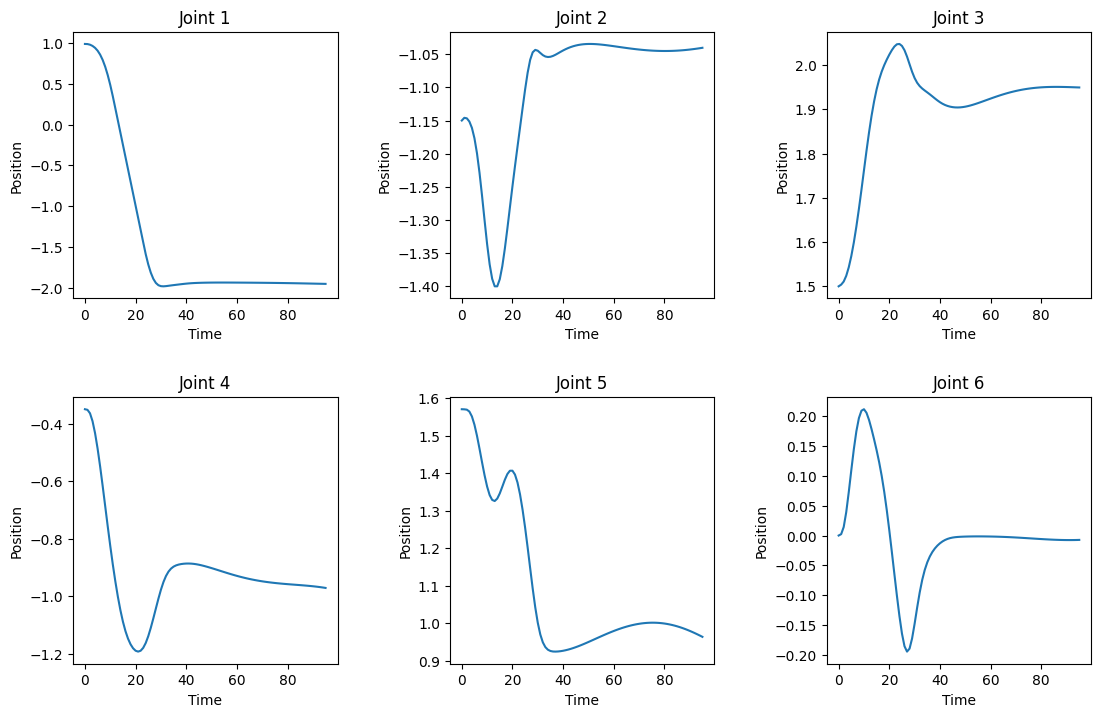

In [50]:
plot_joint_states(joint_pos[:], target="Position")

Joint Vel 0:  [3.30212116 0.76760596 0.91208893 1.43490374 1.13968301 0.77785814]


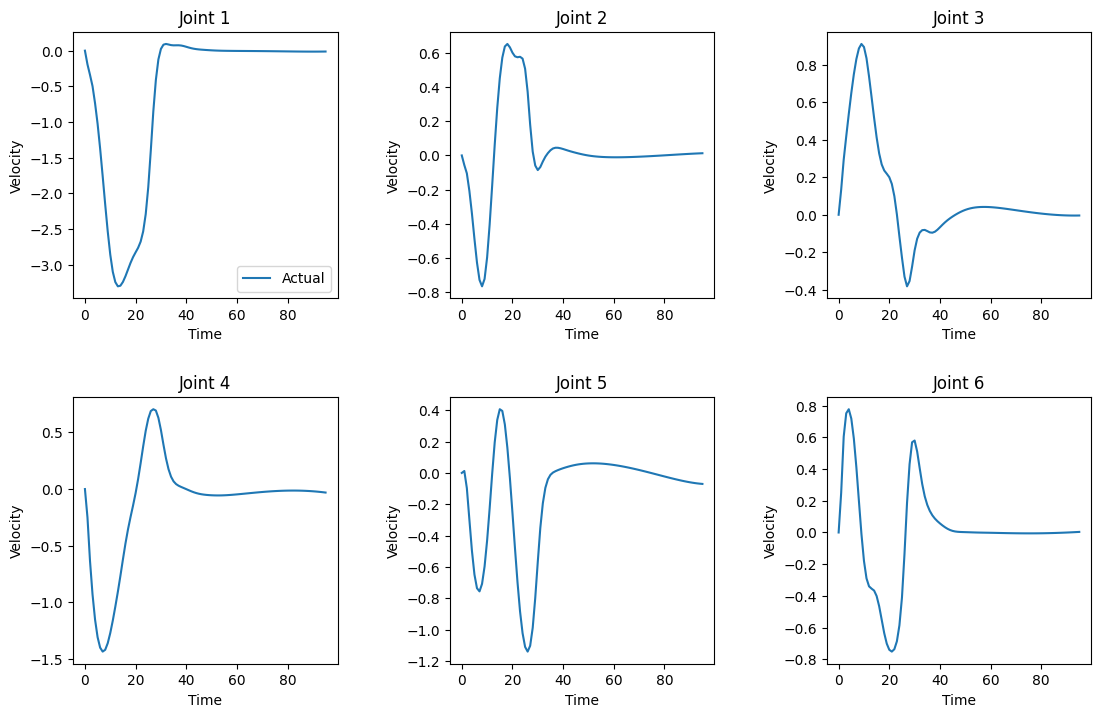

In [51]:
fig, axs=plot_joint_states(joint_vel[:], target="Velocity")
dt = 1/60
joint_vel_hat = np.diff(joint_pos, axis=0)/dt
#fig, axs = plot_joint_states(joint_vel_hat[:], target="Velocity_hat", fig=fig, axs=axs)
print("Joint Vel 0: ", np.abs(joint_vel).max(axis=0))
axs[0,0].legend(["Actual", "Estimated"])

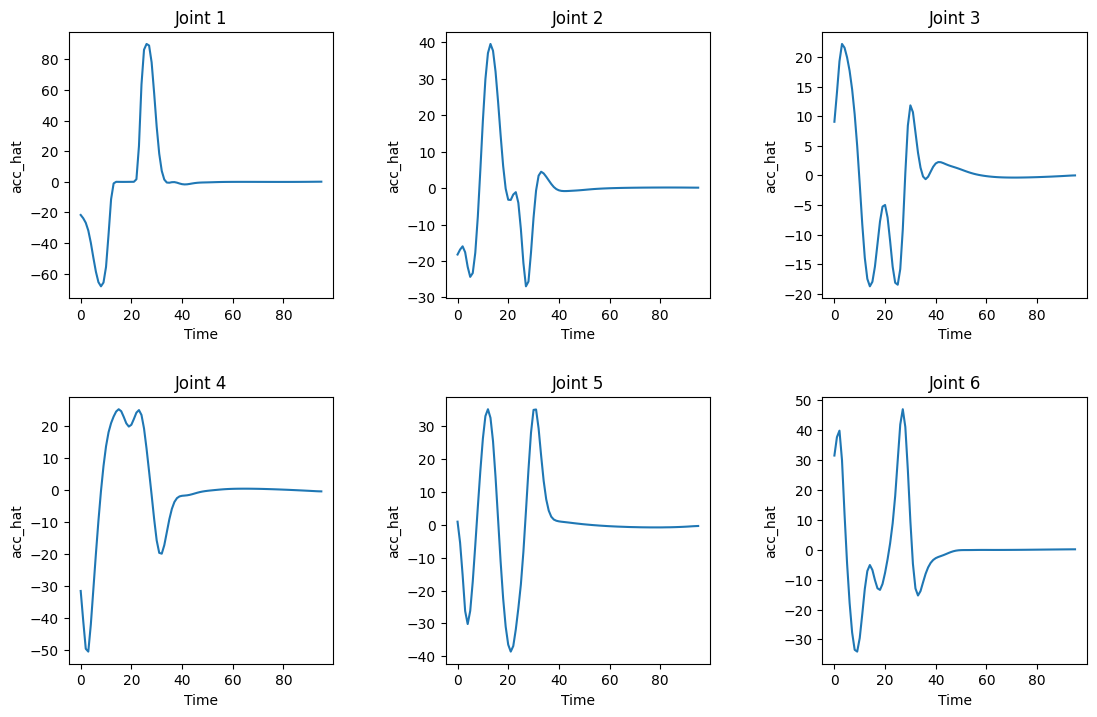

In [52]:

joint_acc_hat_2 = np.gradient(joint_vel, axis=0)/dt

joint_acc_hat_3 = np.gradient(np.gradient(joint_pos, axis=0, edge_order=2), axis=0,edge_order=2)/dt**2
joint_acc_hat_4 = np.gradient(np.gradient(joint_pos, axis=0, edge_order=2), axis=0,edge_order=2)/dt**2

#fig, axs = plot_joint_states(joint_acc_hat_2[:], target="acc_hat_2", fig=fig, axs=axs)
#fig, axs = plot_joint_states(joint_acc_hat[:], target="acc_hat")
fig, axs = plot_joint_states(joint_acc_hat_3[:], target="acc_hat")

#plot_joint_states(joint_acc_hat_3[:], target="Smoothed acc_hat", fig=fig, axs=axs)
#plot_joint_states(joint_acc_hat_4[:], target="Smoothed acc_hat", fig=fig, axs=axs)

#axs[0,0].legend(["acc_hat", "acc_hat2", "acc_hat3"])



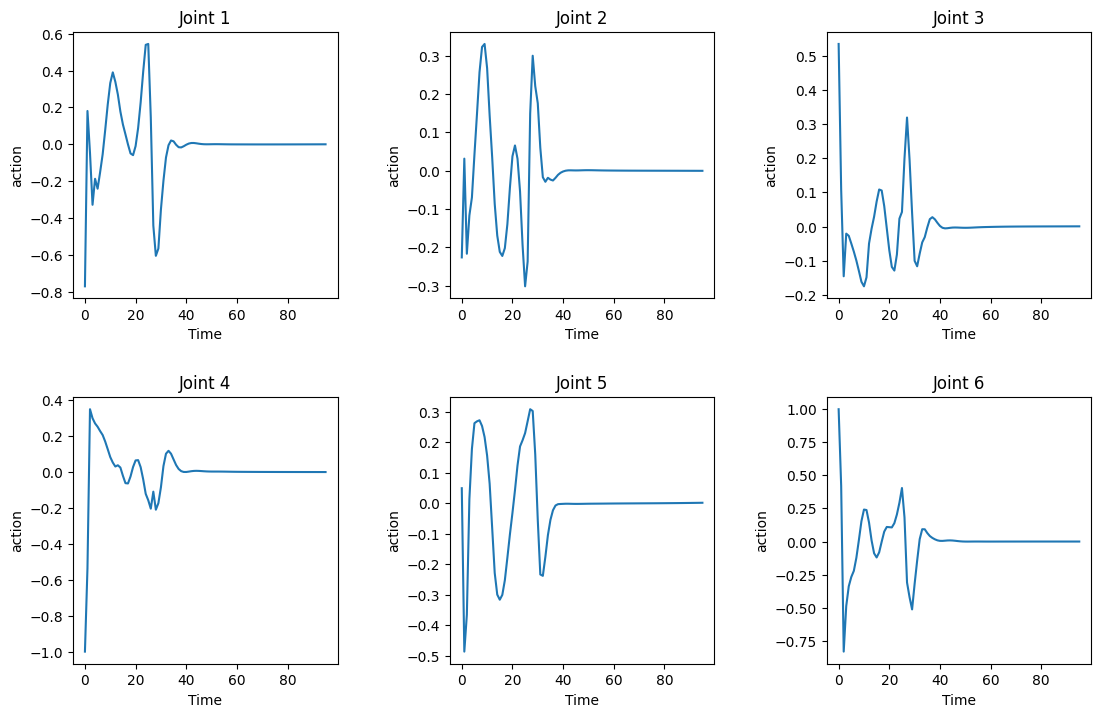

In [53]:
fig, axs = plot_joint_states(action_traj[:], target="action")
#plot_joint_states(action_traj2[:], target="action", fig=fig, axs=axs)


jointacc_traj:  (96, 6)


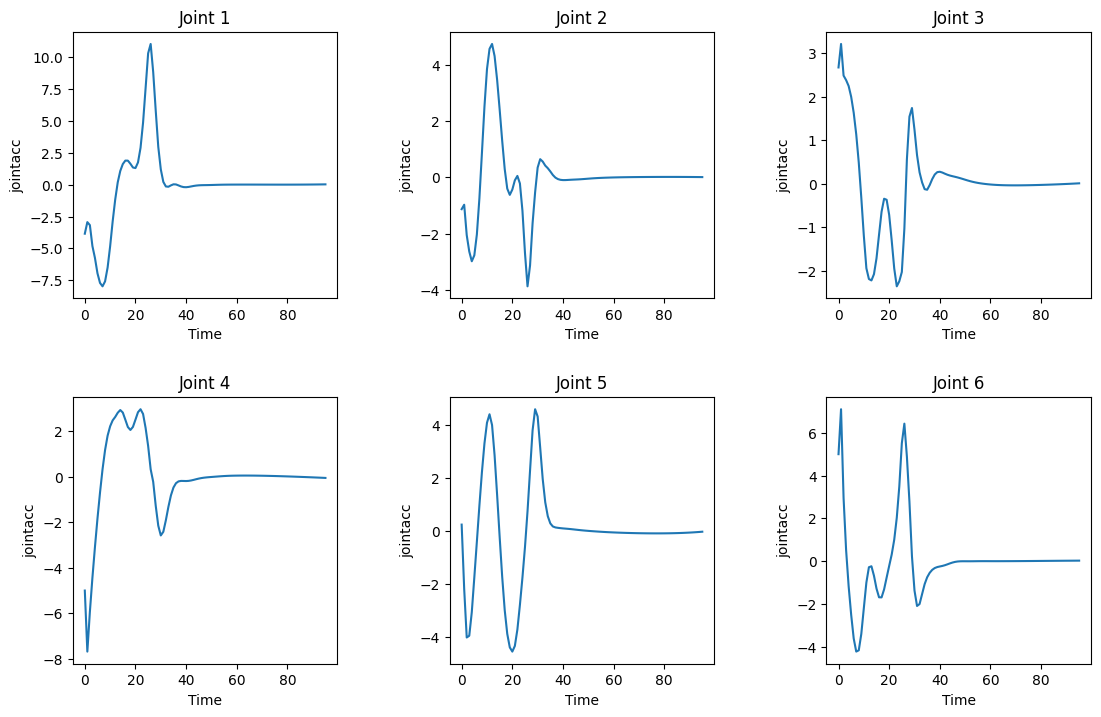

In [54]:
fig, axs = plot_joint_states(jointacc_traj[:], target="jointacc")
print("jointacc_traj: ", jointacc_traj.shape)


In [55]:
X = torch.arange(1*6*3)
print(X)
X = X.reshape(6, 3)
print(X)
print(X[:,-1])

X = X.reshape(-1, 6*3)
print(X)
print(X[:, -6:])

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])
tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]])
tensor([ 2,  5,  8, 11, 14, 17])
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]])
tensor([[12, 13, 14, 15, 16, 17]])


### Process Trajs for real robot deployment


In [56]:
StartPos = []
FinalPos = []
for trajID in succTrajs:
    obs_traj = np.loadtxt(os.path.join(dataset_dir.format(seed), trajID,"obs_traj.txt"), delimiter=',')
    jointPos = obs_traj[:, :6]
    startJointPos = list(jointPos[0])
    finalJointPos = list(jointPos[-1])

    StartPos.append(startJointPos)
    FinalPos.append(finalJointPos)
    
StartPos = np.array(StartPos).round(2)
FinalPos = np.array(FinalPos).round(2)
print("StartPos: ", StartPos)
print("FinalPos: ", FinalPos)

StartPos:  [[ 0.   -0.79  1.58 -0.79  1.57  0.  ]
 [ 0.99 -1.15  1.5  -0.35  1.57  0.  ]
 [-1.57 -0.    0.89 -0.89  1.57  0.  ]
 [ 0.99 -0.54  1.51 -0.97  1.57  0.  ]
 [-1.57  0.25  0.42 -0.67  1.57  0.  ]
 [ 1.05 -0.11  1.15 -1.04  1.57  0.  ]
 [-1.57 -1.03  1.1  -0.07  1.57  0.  ]
 [ 1.15 -0.95  0.99 -0.04  1.57  0.  ]
 [-1.57 -0.83  1.33 -0.5   1.57  0.  ]
 [ 1.21 -0.18  0.73 -0.55  1.57  0.  ]
 [-1.57 -0.13  0.59 -0.46  1.57  0.  ]
 [ 1.07 -0.45  1.27 -0.82  1.57  0.  ]
 [-1.57 -0.48  1.24 -0.76  1.57  0.  ]
 [ 1.07 -1.07  1.28 -0.21  1.57  0.  ]
 [-1.57 -0.83  0.74  0.09  1.57  0.  ]
 [ 1.05 -0.81  1.45 -0.64  1.57  0.  ]
 [-1.57 -0.58  1.49 -0.91  1.57  0.  ]
 [ 1.2  -0.59  0.9  -0.31  1.57  0.  ]
 [-1.57 -0.68  1.02 -0.34  1.57  0.  ]
 [ 0.97 -0.23  1.38 -1.15  1.57  0.  ]
 [-1.57 -1.27  1.68 -0.41  1.57  0.  ]
 [ 0.97 -0.86  1.59 -0.73  1.57  0.  ]
 [-1.57 -0.92  1.59 -0.67  1.57  0.  ]
 [ 1.21  0.21  0.52 -0.73  1.57  0.  ]
 [-1.57 -0.15  1.18 -1.03  1.57  0.  ]
 [ 1.13  0.03 

In [57]:
jointPosDiff = np.zeros(6)
initVel = np.zeros(6)
for trajID in succTrajs:
    obs_traj = np.loadtxt(os.path.join(dataset_dir.format(seed), trajID,"obs_traj.txt"), delimiter=',')
    jointPos = obs_traj[:, :6]
    joint_vel = obs_traj[:, 6:12]
    jointPosDiff += np.abs(init_joint_pos[int(trajID)] - jointPos[0])
    initVel += joint_vel[0]

print("Init Vel: ", initVel/len(succTrajs))
print("Joint Pos Diff: ", jointPosDiff/len(succTrajs))


    

Init Vel:  [0. 0. 0. 0. 0. 0.]
Joint Pos Diff:  [3.52418637e-08 1.46799721e-08 2.47731805e-08 1.24052167e-08
 4.37113901e-08 0.00000000e+00]


jointPosAll shape: (3072, 6)
jointAccAll shape: (3072, 6)
VEL max:  [3.10954332 1.5013752  2.04832315 1.41368878 0.56845409 1.18957257]


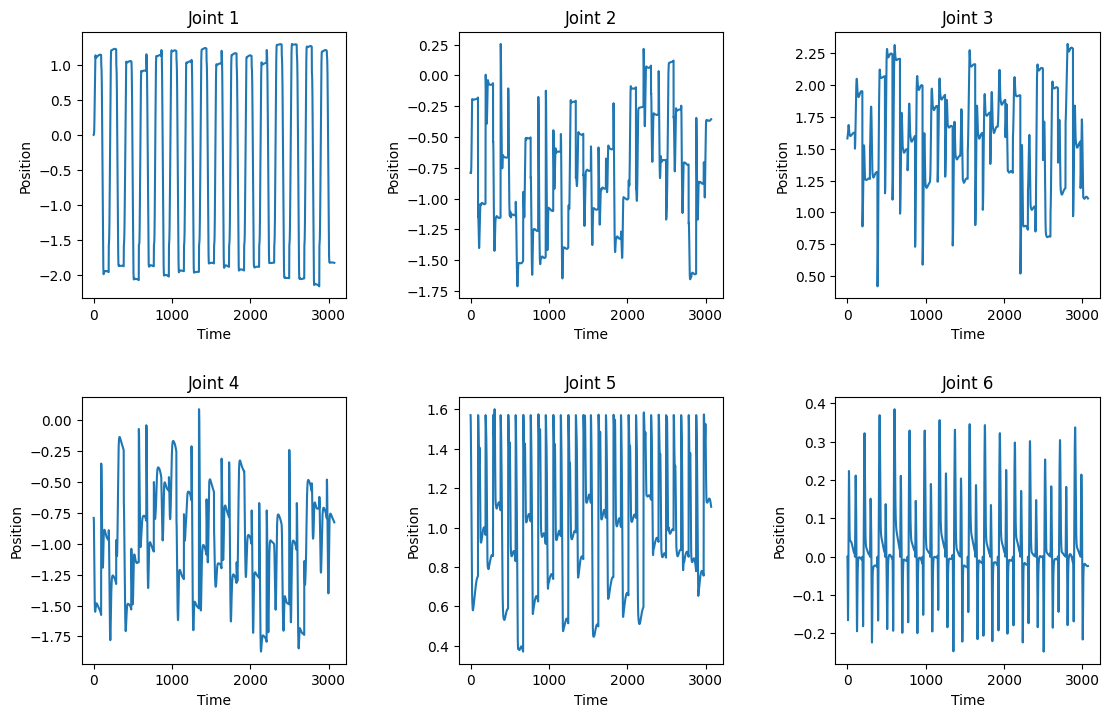

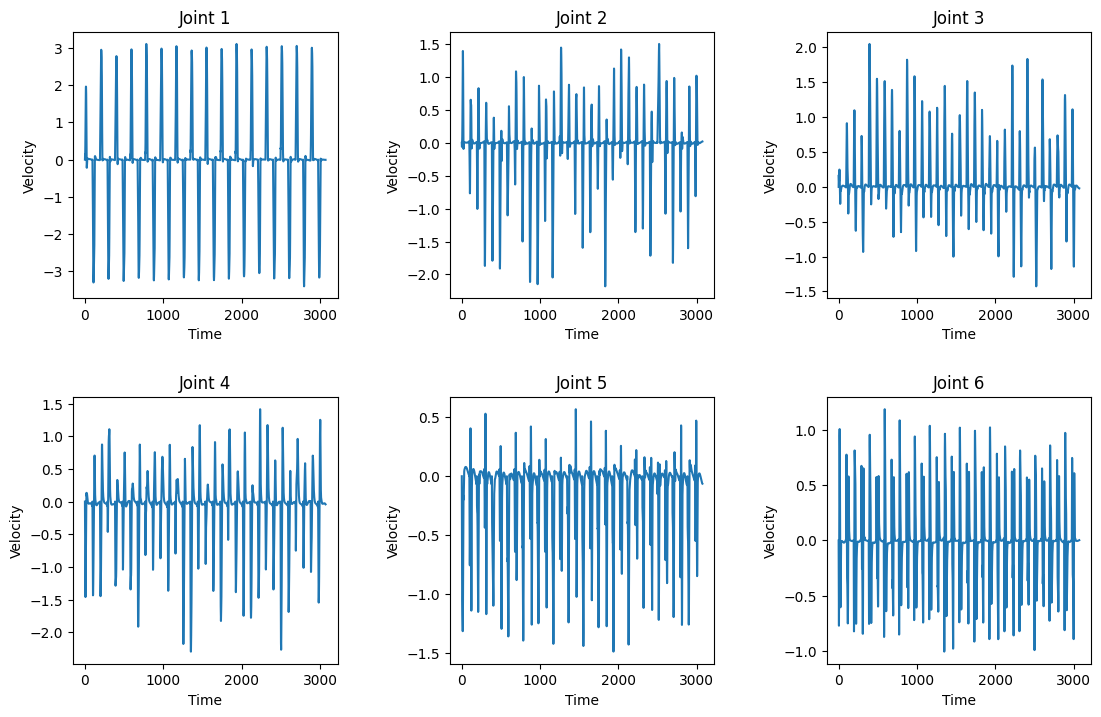

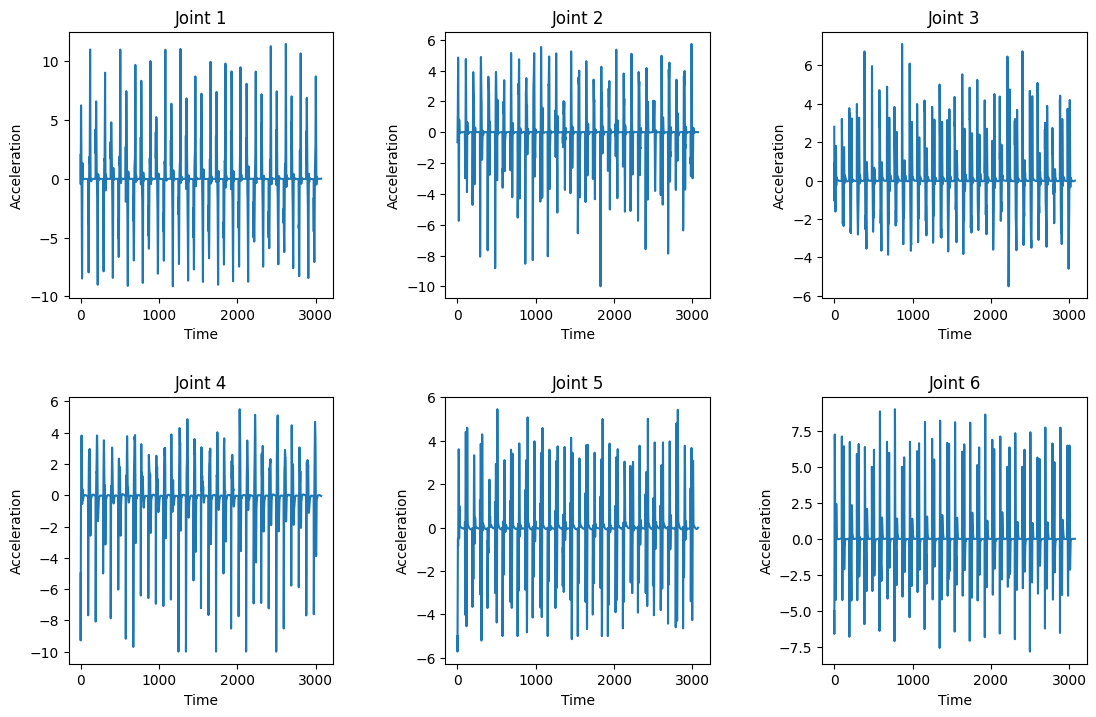

In [58]:
jointPosAll = []
jointVelAll = []
jointAccAll = []


for trajID in succTrajs:
    obs_traj = np.loadtxt(os.path.join(dataset_dir.format(seed), trajID,"obs_traj.txt"), delimiter=',')
    #action_traj = np.loadtxt(os.path.join(dataset_dir.format(seed), trajID,"action_traj.txt"), delimiter=',')[:,:]
    jointAcc = np.loadtxt(os.path.join(dataset_dir.format(seed), trajID,"jointacc_traj.txt"), delimiter=',')[:,:]
    jointPos = obs_traj[:, :6]
    #jointVel_hat = np.gradient(jointPos, axis=0)/dt
    jointVel = obs_traj[:, 6:12]

    
    jointPosAll.append(jointPos)
    #jointVelAll.append(jointVel_hat)
    jointVelAll.append(jointVel)
    jointAccAll.append(jointAcc)

jointPosAll = np.concatenate(jointPosAll, axis=0)
jointVelAll = np.concatenate(jointVelAll, axis=0)
jointAccAll = np.concatenate(jointAccAll, axis=0)

plot_joint_states(jointPosAll, target="Position")
plot_joint_states(jointVelAll, target="Velocity")
plot_joint_states(jointAccAll, target="Acceleration")

print("jointPosAll shape:", jointPosAll.shape)
print("jointAccAll shape:", jointAccAll.shape)

print("VEL max: ", jointVelAll.max(axis=0))

In [59]:
## Save the processed data for real robot deployment
np.save("../scripts/jointPosAll.npy", jointPosAll)
np.save("../scripts/jointVelAll.npy", jointVelAll)
np.save("../scripts/jointAccAll.npy", jointAccAll)



#### Analyze real traj

In [ ]:
traj_id = 1
control_freq = 20
realTraj = np.loadtxt(f"../data/trajID{traj_id}_position_velocity_real_BR2_{control_freq}Hz.csv",  delimiter=',', skiprows=1)
realTraj.shape

Time = realTraj[:, 0]
jointPosReal = realTraj[:, 1:7]
jointVelReal = realTraj[:, 7:13]
jointPosSim = realTraj[:, 13:19]
jointVelSim = realTraj[:, 19:25]
jointAccSim = realTraj[:, 25:31]


#(joint_pos[1:] - joint_pos[:-1] - joint_vel[:-1]*dt_ctrl)/(0.5*dt_ctrl**2)
jointACC_dummy = (jointPosSim[1:] - jointPosSim[:-1] - jointVelSim[:-1]*dt_ctrl)/(0.5*dt_ctrl**2)
joint_pos_hat = np.cumsum(np.cumsum(jointACC_dummy,axis=0)*dt,axis=0)*dt + jointPosSim[0]

FileNotFoundError: ../../data/BR/real/trajID1_position_velocity_real_BR2_20Hz.csv not found.

(<Figure size 1200x800 with 6 Axes>,
 array([[<Axes: title={'center': 'Joint 1'}, xlabel='Time', ylabel='Sim'>,
         <Axes: title={'center': 'Joint 2'}, xlabel='Time', ylabel='Sim'>,
         <Axes: title={'center': 'Joint 3'}, xlabel='Time', ylabel='Sim'>],
        [<Axes: title={'center': 'Joint 4'}, xlabel='Time', ylabel='Sim'>,
         <Axes: title={'center': 'Joint 5'}, xlabel='Time', ylabel='Sim'>,
         <Axes: title={'center': 'Joint 6'}, xlabel='Time', ylabel='Sim'>]],
       dtype=object))

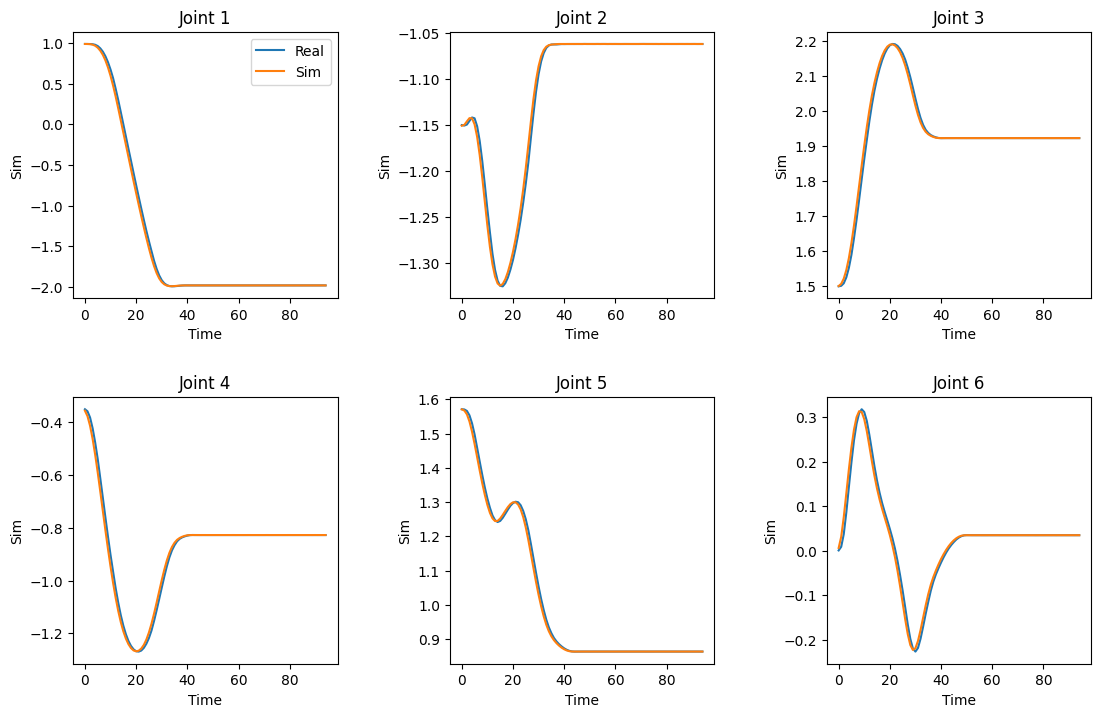

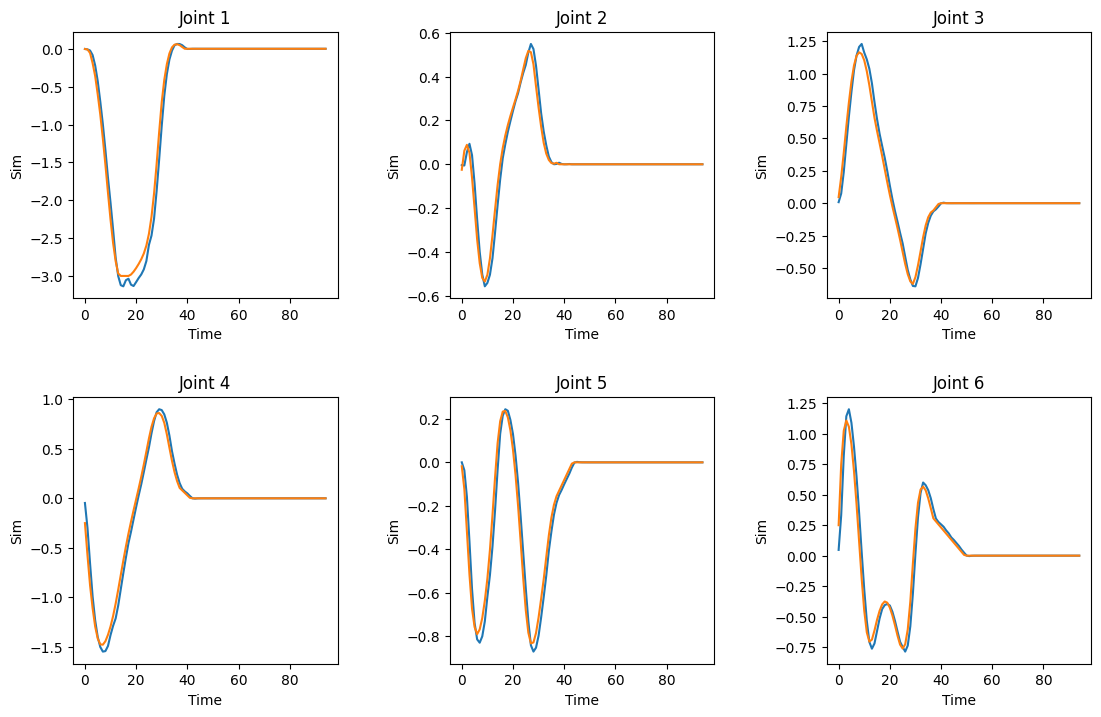

In [ ]:
fig, ax = plot_joint_states(jointPosReal[:-1], target="Real")
plot_joint_states(jointPosSim[1:], target="Sim", fig=fig, axs=ax)
#plot_joint_states(joint_pos_hat, target="Sim", fig=fig, axs=ax)
ax[0,0].legend(["Real", "Sim","Est"])

fig, ax = plot_joint_states(jointVelReal[:-1], target="Real")
plot_joint_states(jointVelSim[1:], target="Sim", fig=fig, axs=ax)